In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os
from typing import Dict, List, Tuple, Union

# from model import CrimeModel

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, f1_score

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
class CrimeModel(tf.keras.Model):

    def __init__(self, units=32):

        super(CrimeModel, self).__init__()

        self.lstm = tf.keras.layers.GRU(16)
        self.dense = tf.keras.layers.Dense(4, activation='relu')
        self.final = tf.keras.layers.Dense(1, activation='sigmoid')

    def __call__(self, x, training):

        x = self.lstm(x)
        x = self.dense(x)
        x = self.final(x)

        return x

In [4]:
LOAD_PATH = '../data/npys/14'
CITY = 'New York'
YEAR = 2014
MODEL = 'xgboost'
TEST_SIZE = 0.15
USE_EMBEDDING = False

In [5]:
def load_data(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Loads the data from path for a spesific city.
    The type of the data to load is based on the model used.

    Parameters
    ----------
    path: str
        Path of the data.

    Returns
    -------
    X: np.ndarray
        Numpy array of inputs for the model.

    y: np.ndarray
        Numpy array of labels.
    """

    train = np.load(f'{path}/train.npz')
    tests = {}
    for month in os.listdir(f'{path}/test'):
        month_path = f'{path}/test/{month}'
        tests[month.split('.')[0]] = np.load(month_path)

    return train, tests

In [6]:
def train_model(model_type: str,
                train: np.lib.npyio.NpzFile,
                test: np.lib.npyio.NpzFile,
                crime: str,
                data_type: str,
                test_size: float=0.2) -> None:

    x, y = train['x'], train['y']
    
#     x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, shuffle=False, random_state=42)
    
    weight_ratio = float(len(y[y == 1])) / float(len(y[y == 0]))

    results = pd.DataFrame({'crime': [],'model': [], 'data_type': [], 'month': [],'f1': [], 'auc': []})
    
    if model_type == 'xgboost':
        model = XGBClassifier(n_estimators=200, objective='binary:logistic',
                              n_jobs=-1,
                              eval_metric='logloss')

        model.fit(x, y)
        
        for month in test:
            x_test, y_test = test[month]['x'], test[month]['y']
            proba = model.predict_proba(x_test)[:, 1]
            preds = model.predict(x_test)
            
            auc = round(roc_auc_score(y_test, proba), 4)
            f1 = round(f1_score(y_test, preds), 4)
            
            results = results.append(pd.Series({'crime': crime,
                                      'model': model_type,
                                      'data_type':  data_type,
                                      'month': month,
                                      'f1': f1,
                                      'auc': auc}), ignore_index=True)

    else:
        model = CrimeModel(32)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

        model.fit(x, y, epochs=5, batch_size=64, verbose=0)
        
        for month in test:
            x_test, y_test = test[month]['x'], test[month]['y']
            proba = model.predict(x_test, batch_size=64)
            preds = [1 if prob > 0.5 else 0 for prob in proba]
            
            auc = round(roc_auc_score(y_test, proba), 4)
            f1 = round(f1_score(y_test, preds), 4)
            
            results = results.append(pd.Series({'crime': crime,
                                      'model': model_type,
                                      'data_type':  data_type,
                                      'month': month,
                                      'f1': f1,
                                      'auc': auc}), ignore_index=True)
        
        
    return results
    

In [7]:
df = pd.DataFrame({'crime': [],'model': [], 'month': [],'f1': [], 'auc': []})

for data_type in (t1 := tqdm(['historic', 'embedding'])):
    t1.set_description(f'{data_type}')
    
    if MODEL == 'xgboost':
        path = f'{LOAD_PATH}/{data_type}/regular/{YEAR}'

    elif MODEL == 'tensorflow':
        path = f'{LOAD_PATH}/{data_type}/time_series/{YEAR}'
    
    for crime in (t2 := tqdm(os.listdir(path), leave=False)):
        t2.set_description(f'{crime}')
        crime_path = f'{path}/{crime}'
        train, tests = load_data(crime_path)
        results = train_model(MODEL, train, tests, crime, data_type, TEST_SIZE)
        df = df.append(results)
df.index = range(df.shape[0])

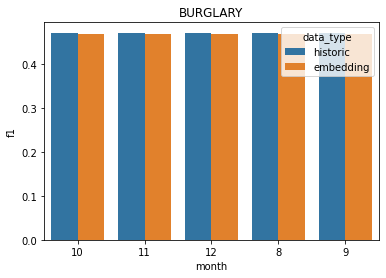

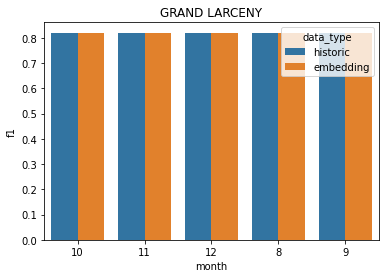

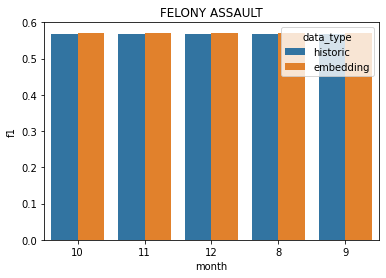

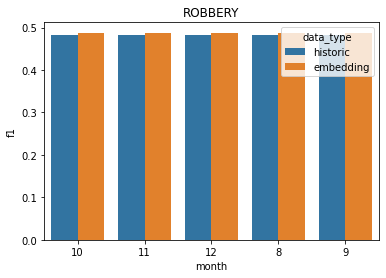

In [8]:
for crime in df.crime.unique():
    crime_df = df[df.crime == crime]
    ax = sns.barplot(data=crime_df, x='month', y='f1', hue='data_type')
    ax.set_title(f'{crime}')
    plt.show()

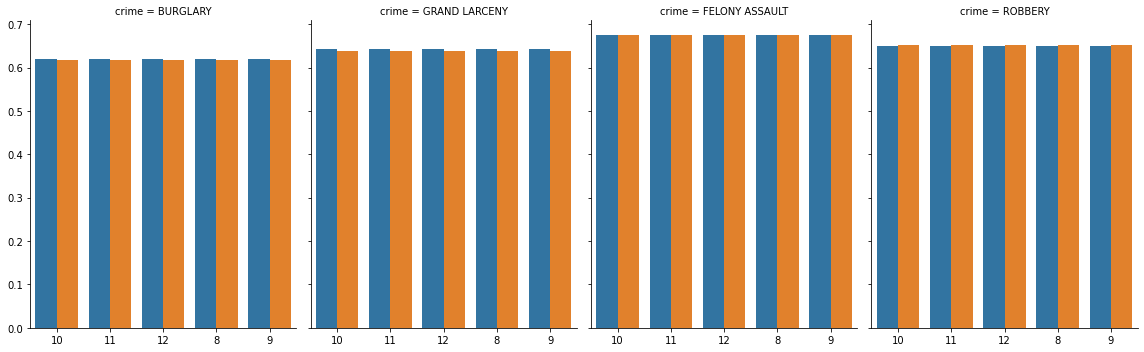

In [41]:
g = sns.FacetGrid(df, col="crime", height=5, aspect=0.8)
ax = g.map_dataframe(sns.barplot, x="month", y="auc", hue="data_type", palette=sns.color_palette("tab10"))


In [17]:
ax.savefig("output.png")